# Modelagem Preditiva de Sucesso de Projetos

Este notebook executa o pipeline de modelagem preditiva para o sucesso de projetos, utilizando a base histórica gerada no fluxo de produção. O objetivo é garantir que o pipeline seja idêntico ao utilizado em produção, facilitando manutenção e reprodutibilidade.

## 1. Importação de Bibliotecas e Configurações

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFE
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, precision_recall_curve
from imblearn.combine import SMOTEENN
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

# Caminhos de entrada e saída compatíveis com produção
INPUT_PROJETOS = '../data/historico_projetos.csv'
OUTPUT_MODEL = '../model.pkl'
RANDOM_STATE = 42

## 2. Carregamento dos Dados

In [3]:
df = pd.read_csv(INPUT_PROJETOS)
print('Shape:', df.shape)
df.head()

Shape: (353, 7)


,id_usuario,nome_usuario,projeto_id,orcamento,duracao,sucesso,data_inicio
0,1,Usuário 1,1_1,18568,12,1,2020-09-09
1,1,Usuário 1,1_2,9666,10,1,2021-11-30
2,1,Usuário 1,1_3,1189,15,1,2022-05-25
3,1,Usuário 1,1_4,2267,3,0,2021-10-08
4,1,Usuário 1,1_5,15502,18,0,2020-11-11


In [ ]:
print('Colunas disponíveis:', df.columns.tolist())

Colunas disponíveis: ['id_usuario', 'nome_usuario', 'projeto_id', 'orcamento', 'duracao', 'sucesso', 'data_inicio']


## 3. Engenharia de features

In [7]:
# Engenharia de features
if 'recursos_disponiveis' in df.columns:
df = pd.get_dummies(df, columns=['recursos_disponiveis'], prefix='recursos')
# Se as colunas já existem, segue normalmente
df['orcamento_por_membro'] = df['orcamento'] / df['numero_membros_equipe'] if 'numero_membros_equipe' in df.columns else np.nan
df['duracao_por_membro'] = df['duracao'] / df['numero_membros_equipe'] if 'numero_membros_equipe' in df.columns else np.nan
df['duracao_x_equipe'] = df['duracao'] * df['numero_membros_equipe'] if 'numero_membros_equipe' in df.columns else np.nan
df['equipe_extrema'] = df['numero_membros_equipe'].apply(lambda x: 1 if x <= 2 or x >= 12 else 0) if 'numero_membros_equipe' in df.columns else 0
df['orcamento_por_recurso'] = df['orcamento'] / (df.get('recursos_Baixo',0) + 2*df.get('recursos_Médio',0) + 3*df.get('recursos_Alto',0) + 1e-10)
df['recursos_por_membro'] = (df.get('recursos_Baixo',0) + 2*df.get('recursos_Médio',0) + 3*df.get('recursos_Alto',0)) / df['numero_membros_equipe'] if 'numero_membros_equipe' in df.columns else np.nan
orcamento_threshold = df['orcamento'].quantile(0.25)
df['orcamento_baixo'] = (df['orcamento'] <= orcamento_threshold).astype(int)
duracao_threshold = df['duracao'].quantile(0.25)
df['duracao_curta'] = (df['duracao'] <= duracao_threshold).astype(int)
df['duracao_por_recurso'] = df['duracao'] / (df.get('recursos_Baixo',0) + 2*df.get('recursos_Médio',0) + 3*df.get('recursos_Alto',0) + 1e-10)
df['orcamento_por_duracao'] = df['orcamento'] / (df['duracao'] + 1e-10)

In [10]:
print('Colunas após engenharia de features:', df.columns.tolist())

Colunas após engenharia de features: ['id_usuario', 'nome_usuario', 'projeto_id', 'orcamento', 'duracao', 'sucesso', 'data_inicio', 'orcamento_por_membro', 'duracao_por_membro', 'duracao_x_equipe', 'equipe_extrema', 'orcamento_por_recurso', 'recursos_por_membro', 'orcamento_baixo', 'duracao_curta', 'duracao_por_recurso', 'orcamento_por_duracao']


## 4. Treinamento dos modelos


Melhores parâmetros para Regressão Logística: {'C': 100, 'penalty': 'l1', 'solver': 'liblinear'}

Regressão Logística
F1-Score médio (CV): 0.9826 ± 0.0213
Accuracy: 0.5070
Precision: 0.6667
Recall: 0.6000
F1 Score: 0.6316
Confusion Matrix:
[[ 6 15]
 [20 30]]
Melhor limiar para F1: 0.3000 (F1: 0.8264)

Análise detalhada de erros para Regressão Logística:
      orcamento   duracao  orcamento_por_membro  duracao_por_membro  \
343   0.579767 -0.167468                   0.0                 0.0   
22    0.344186 -1.367799                   0.0                 0.0   
289  -0.769870 -1.517841                   0.0                 0.0   
71    0.704562 -1.217758                   0.0                 0.0   
244  -0.811528 -0.317510                   0.0                 0.0   

     duracao_x_equipe  equipe_extrema  orcamento_por_recurso  \
343               0.0               0               0.579767   
22                0.0               0               0.344186   
289               0.0        


Melhores parâmetros para Regressão Logística: {'C': 100, 'penalty': 'l1', 'solver': 'liblinear'}

Regressão Logística
F1-Score médio (CV): 0.9826 ± 0.0213
Accuracy: 0.5070
Precision: 0.6667
Recall: 0.6000
F1 Score: 0.6316
Confusion Matrix:
[[ 6 15]
 [20 30]]
Melhor limiar para F1: 0.3000 (F1: 0.8264)

Análise detalhada de erros para Regressão Logística:
      orcamento   duracao  orcamento_por_membro  duracao_por_membro  \
343   0.579767 -0.167468                   0.0                 0.0   
22    0.344186 -1.367799                   0.0                 0.0   
289  -0.769870 -1.517841                   0.0                 0.0   
71    0.704562 -1.217758                   0.0                 0.0   
244  -0.811528 -0.317510                   0.0                 0.0   

     duracao_x_equipe  equipe_extrema  orcamento_por_recurso  \
343               0.0               0               0.579767   
22                0.0               0               0.344186   
289               0.0        

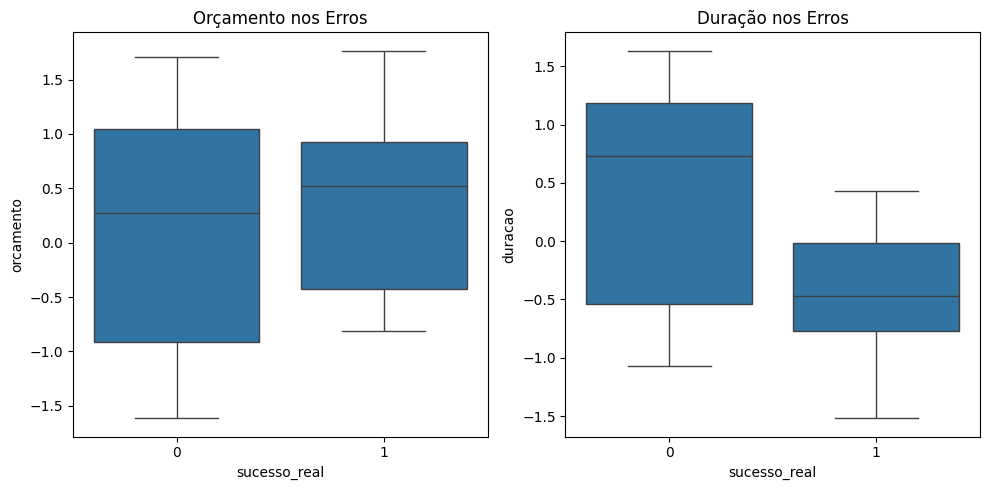


Melhores parâmetros para Regressão Logística: {'C': 100, 'penalty': 'l1', 'solver': 'liblinear'}

Regressão Logística
F1-Score médio (CV): 0.9826 ± 0.0213
Accuracy: 0.5070
Precision: 0.6667
Recall: 0.6000
F1 Score: 0.6316
Confusion Matrix:
[[ 6 15]
 [20 30]]
Melhor limiar para F1: 0.3000 (F1: 0.8264)

Análise detalhada de erros para Regressão Logística:
      orcamento   duracao  orcamento_por_membro  duracao_por_membro  \
343   0.579767 -0.167468                   0.0                 0.0   
22    0.344186 -1.367799                   0.0                 0.0   
289  -0.769870 -1.517841                   0.0                 0.0   
71    0.704562 -1.217758                   0.0                 0.0   
244  -0.811528 -0.317510                   0.0                 0.0   

     duracao_x_equipe  equipe_extrema  orcamento_por_recurso  \
343               0.0               0               0.579767   
22                0.0               0               0.344186   
289               0.0        

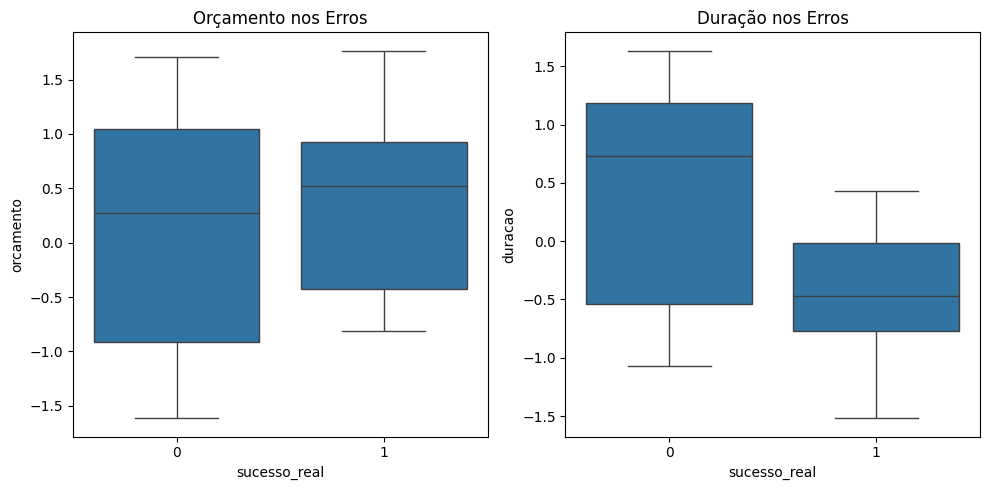


Melhores parâmetros para Random Forest: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 300}

Random Forest
F1-Score médio (CV): 0.9415 ± 0.0600
Accuracy: 0.7183
Precision: 0.7273
Recall: 0.9600
F1 Score: 0.8276
Confusion Matrix:
[[ 3 18]
 [ 2 48]]
Melhor limiar para F1: 0.4925 (F1: 0.8376)

Importância das Features para Random Forest:
Feature: orcamento, Importância: 0.2339
Feature: duracao, Importância: 0.1196
Feature: orcamento_por_membro, Importância: 0.0000
Feature: duracao_por_membro, Importância: 0.0000
Feature: duracao_x_equipe, Importância: 0.0000
Feature: equipe_extrema, Importância: 0.0000
Feature: orcamento_por_recurso, Importância: 0.2638
Feature: recursos_por_membro, Importância: 0.0000
Feature: orcamento_baixo, Importância: 0.0765
Feature: duracao_curta, Importância: 0.0197
Feature: duracao_por_recurso, Importância: 0.1050
Feature: orcamento_por_duracao, Importância: 0.1814

Análise detalhada de erros para Random 


Melhores parâmetros para Regressão Logística: {'C': 100, 'penalty': 'l1', 'solver': 'liblinear'}

Regressão Logística
F1-Score médio (CV): 0.9826 ± 0.0213
Accuracy: 0.5070
Precision: 0.6667
Recall: 0.6000
F1 Score: 0.6316
Confusion Matrix:
[[ 6 15]
 [20 30]]
Melhor limiar para F1: 0.3000 (F1: 0.8264)

Análise detalhada de erros para Regressão Logística:
      orcamento   duracao  orcamento_por_membro  duracao_por_membro  \
343   0.579767 -0.167468                   0.0                 0.0   
22    0.344186 -1.367799                   0.0                 0.0   
289  -0.769870 -1.517841                   0.0                 0.0   
71    0.704562 -1.217758                   0.0                 0.0   
244  -0.811528 -0.317510                   0.0                 0.0   

     duracao_x_equipe  equipe_extrema  orcamento_por_recurso  \
343               0.0               0               0.579767   
22                0.0               0               0.344186   
289               0.0        

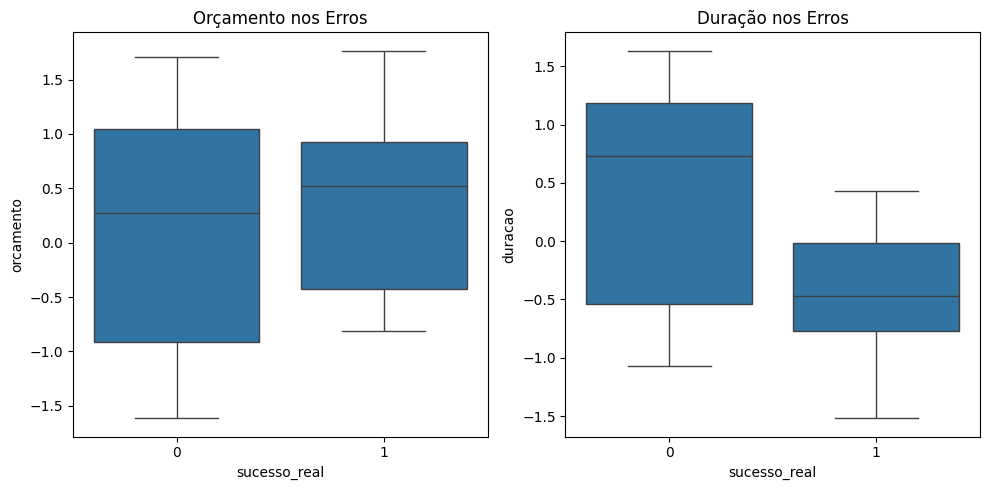


Melhores parâmetros para Random Forest: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 300}

Random Forest
F1-Score médio (CV): 0.9415 ± 0.0600
Accuracy: 0.7183
Precision: 0.7273
Recall: 0.9600
F1 Score: 0.8276
Confusion Matrix:
[[ 3 18]
 [ 2 48]]
Melhor limiar para F1: 0.4925 (F1: 0.8376)

Importância das Features para Random Forest:
Feature: orcamento, Importância: 0.2339
Feature: duracao, Importância: 0.1196
Feature: orcamento_por_membro, Importância: 0.0000
Feature: duracao_por_membro, Importância: 0.0000
Feature: duracao_x_equipe, Importância: 0.0000
Feature: equipe_extrema, Importância: 0.0000
Feature: orcamento_por_recurso, Importância: 0.2638
Feature: recursos_por_membro, Importância: 0.0000
Feature: orcamento_baixo, Importância: 0.0765
Feature: duracao_curta, Importância: 0.0197
Feature: duracao_por_recurso, Importância: 0.1050
Feature: orcamento_por_duracao, Importância: 0.1814

Análise detalhada de erros para Random 

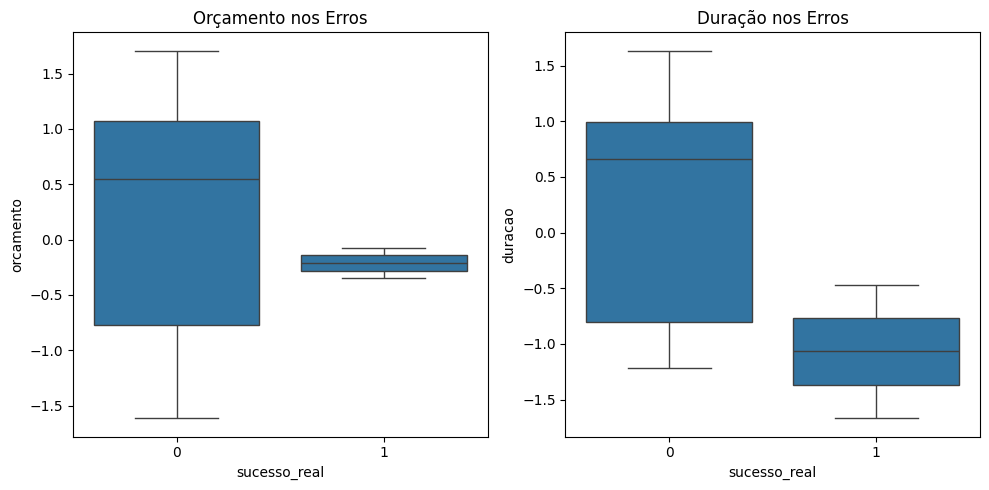


Melhores parâmetros para Regressão Logística: {'C': 100, 'penalty': 'l1', 'solver': 'liblinear'}

Regressão Logística
F1-Score médio (CV): 0.9826 ± 0.0213
Accuracy: 0.5070
Precision: 0.6667
Recall: 0.6000
F1 Score: 0.6316
Confusion Matrix:
[[ 6 15]
 [20 30]]
Melhor limiar para F1: 0.3000 (F1: 0.8264)

Análise detalhada de erros para Regressão Logística:
      orcamento   duracao  orcamento_por_membro  duracao_por_membro  \
343   0.579767 -0.167468                   0.0                 0.0   
22    0.344186 -1.367799                   0.0                 0.0   
289  -0.769870 -1.517841                   0.0                 0.0   
71    0.704562 -1.217758                   0.0                 0.0   
244  -0.811528 -0.317510                   0.0                 0.0   

     duracao_x_equipe  equipe_extrema  orcamento_por_recurso  \
343               0.0               0               0.579767   
22                0.0               0               0.344186   
289               0.0        

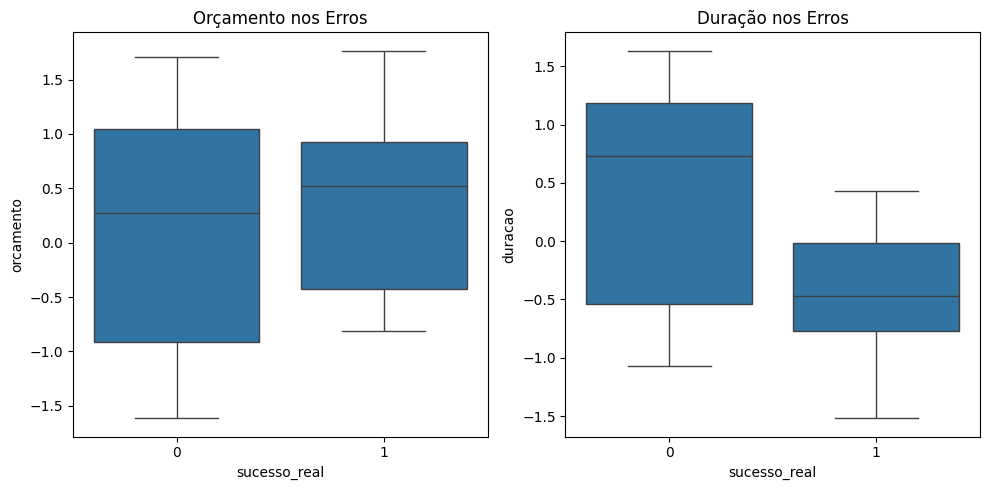


Melhores parâmetros para Random Forest: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 300}

Random Forest
F1-Score médio (CV): 0.9415 ± 0.0600
Accuracy: 0.7183
Precision: 0.7273
Recall: 0.9600
F1 Score: 0.8276
Confusion Matrix:
[[ 3 18]
 [ 2 48]]
Melhor limiar para F1: 0.4925 (F1: 0.8376)

Importância das Features para Random Forest:
Feature: orcamento, Importância: 0.2339
Feature: duracao, Importância: 0.1196
Feature: orcamento_por_membro, Importância: 0.0000
Feature: duracao_por_membro, Importância: 0.0000
Feature: duracao_x_equipe, Importância: 0.0000
Feature: equipe_extrema, Importância: 0.0000
Feature: orcamento_por_recurso, Importância: 0.2638
Feature: recursos_por_membro, Importância: 0.0000
Feature: orcamento_baixo, Importância: 0.0765
Feature: duracao_curta, Importância: 0.0197
Feature: duracao_por_recurso, Importância: 0.1050
Feature: orcamento_por_duracao, Importância: 0.1814

Análise detalhada de erros para Random 

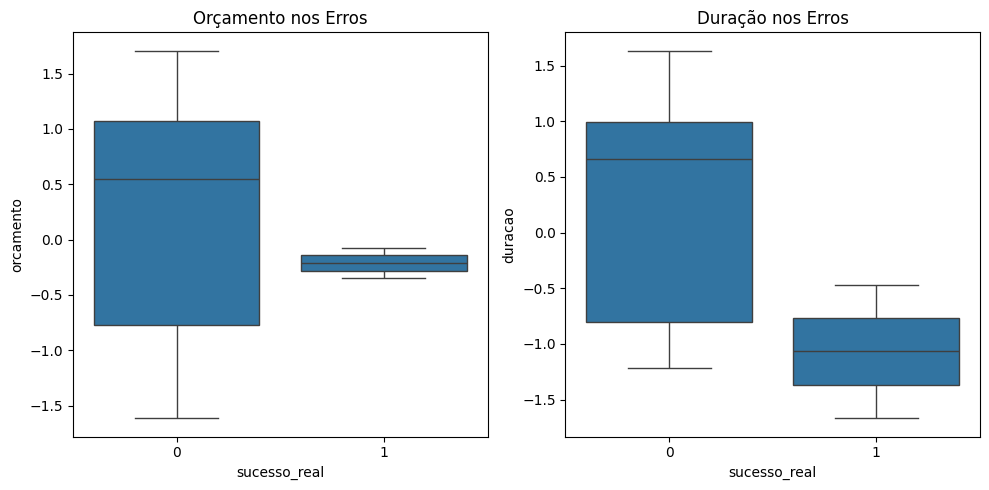


Melhores parâmetros para XGBoost: {'colsample_bytree': 0.7, 'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 300, 'scale_pos_weight': 2, 'subsample': 0.9}

XGBoost
F1-Score médio (CV): 0.9452 ± 0.0527
Accuracy: 0.7042
Precision: 0.7377
Recall: 0.9000
F1 Score: 0.8108
Confusion Matrix:
[[ 5 16]
 [ 5 45]]
Melhor limiar para F1: 0.3221 (F1: 0.8376)

XGBoost
F1-Score médio (CV): 0.9452 ± 0.0527
Accuracy: 0.7042
Precision: 0.7377
Recall: 0.9000
F1 Score: 0.8108
Confusion Matrix:
[[ 5 16]
 [ 5 45]]
Melhor limiar para F1: 0.3221 (F1: 0.8376)

Melhores parâmetros para CatBoost: {'depth': 6, 'iterations': 300, 'l2_leaf_reg': 3, 'learning_rate': 0.01}

Melhores parâmetros para CatBoost: {'depth': 6, 'iterations': 300, 'l2_leaf_reg': 3, 'learning_rate': 0.01}

CatBoost
F1-Score médio (CV): 0.9826 ± 0.0213
Accuracy: 0.5915
Precision: 0.7059
Recall: 0.7200
F1 Score: 0.7129
Confusion Matrix:
[[ 6 15]
 [14 36]]
Melhor limiar para F1: 0.3000 (F1: 0.8376)

Importância das Features para CatBoost:


Melhores parâmetros para Regressão Logística: {'C': 100, 'penalty': 'l1', 'solver': 'liblinear'}

Regressão Logística
F1-Score médio (CV): 0.9826 ± 0.0213
Accuracy: 0.5070
Precision: 0.6667
Recall: 0.6000
F1 Score: 0.6316
Confusion Matrix:
[[ 6 15]
 [20 30]]
Melhor limiar para F1: 0.3000 (F1: 0.8264)

Análise detalhada de erros para Regressão Logística:
      orcamento   duracao  orcamento_por_membro  duracao_por_membro  \
343   0.579767 -0.167468                   0.0                 0.0   
22    0.344186 -1.367799                   0.0                 0.0   
289  -0.769870 -1.517841                   0.0                 0.0   
71    0.704562 -1.217758                   0.0                 0.0   
244  -0.811528 -0.317510                   0.0                 0.0   

     duracao_x_equipe  equipe_extrema  orcamento_por_recurso  \
343               0.0               0               0.579767   
22                0.0               0               0.344186   
289               0.0        

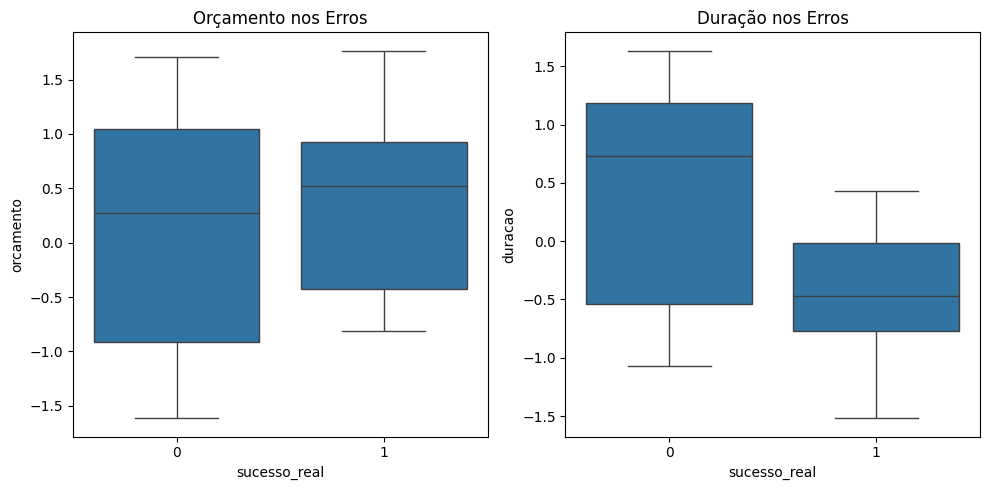


Melhores parâmetros para Random Forest: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 300}

Random Forest
F1-Score médio (CV): 0.9415 ± 0.0600
Accuracy: 0.7183
Precision: 0.7273
Recall: 0.9600
F1 Score: 0.8276
Confusion Matrix:
[[ 3 18]
 [ 2 48]]
Melhor limiar para F1: 0.4925 (F1: 0.8376)

Importância das Features para Random Forest:
Feature: orcamento, Importância: 0.2339
Feature: duracao, Importância: 0.1196
Feature: orcamento_por_membro, Importância: 0.0000
Feature: duracao_por_membro, Importância: 0.0000
Feature: duracao_x_equipe, Importância: 0.0000
Feature: equipe_extrema, Importância: 0.0000
Feature: orcamento_por_recurso, Importância: 0.2638
Feature: recursos_por_membro, Importância: 0.0000
Feature: orcamento_baixo, Importância: 0.0765
Feature: duracao_curta, Importância: 0.0197
Feature: duracao_por_recurso, Importância: 0.1050
Feature: orcamento_por_duracao, Importância: 0.1814

Análise detalhada de erros para Random 

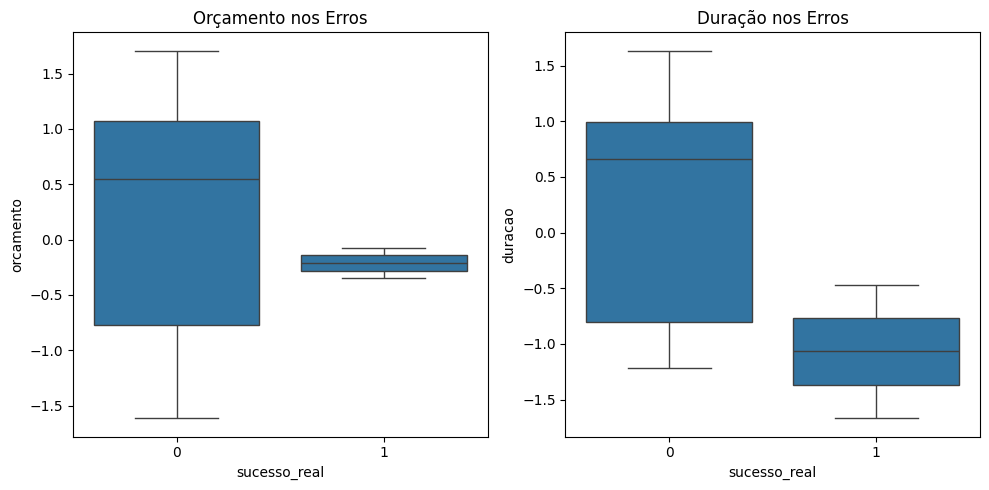


Melhores parâmetros para XGBoost: {'colsample_bytree': 0.7, 'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 300, 'scale_pos_weight': 2, 'subsample': 0.9}

XGBoost
F1-Score médio (CV): 0.9452 ± 0.0527
Accuracy: 0.7042
Precision: 0.7377
Recall: 0.9000
F1 Score: 0.8108
Confusion Matrix:
[[ 5 16]
 [ 5 45]]
Melhor limiar para F1: 0.3221 (F1: 0.8376)

XGBoost
F1-Score médio (CV): 0.9452 ± 0.0527
Accuracy: 0.7042
Precision: 0.7377
Recall: 0.9000
F1 Score: 0.8108
Confusion Matrix:
[[ 5 16]
 [ 5 45]]
Melhor limiar para F1: 0.3221 (F1: 0.8376)

Melhores parâmetros para CatBoost: {'depth': 6, 'iterations': 300, 'l2_leaf_reg': 3, 'learning_rate': 0.01}

Melhores parâmetros para CatBoost: {'depth': 6, 'iterations': 300, 'l2_leaf_reg': 3, 'learning_rate': 0.01}

CatBoost
F1-Score médio (CV): 0.9826 ± 0.0213
Accuracy: 0.5915
Precision: 0.7059
Recall: 0.7200
F1 Score: 0.7129
Confusion Matrix:
[[ 6 15]
 [14 36]]
Melhor limiar para F1: 0.3000 (F1: 0.8376)

Importância das Features para CatBoost:

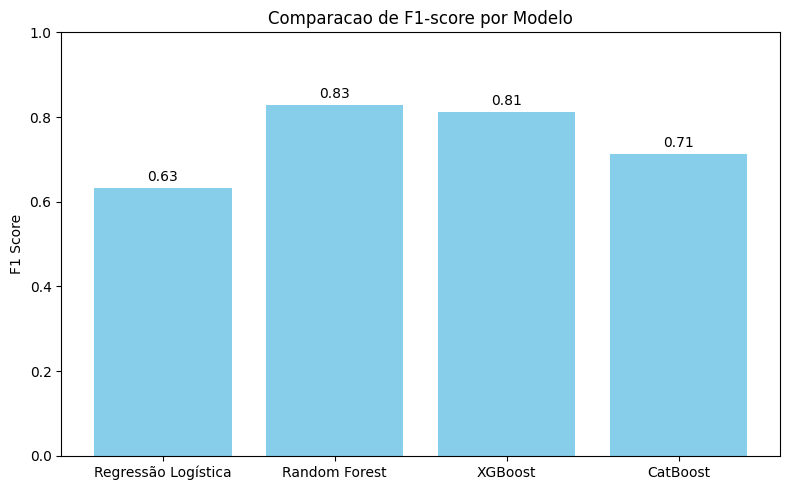


Melhores parâmetros para Regressão Logística: {'C': 100, 'penalty': 'l1', 'solver': 'liblinear'}

Regressão Logística
F1-Score médio (CV): 0.9826 ± 0.0213
Accuracy: 0.5070
Precision: 0.6667
Recall: 0.6000
F1 Score: 0.6316
Confusion Matrix:
[[ 6 15]
 [20 30]]
Melhor limiar para F1: 0.3000 (F1: 0.8264)

Análise detalhada de erros para Regressão Logística:
      orcamento   duracao  orcamento_por_membro  duracao_por_membro  \
343   0.579767 -0.167468                   0.0                 0.0   
22    0.344186 -1.367799                   0.0                 0.0   
289  -0.769870 -1.517841                   0.0                 0.0   
71    0.704562 -1.217758                   0.0                 0.0   
244  -0.811528 -0.317510                   0.0                 0.0   

     duracao_x_equipe  equipe_extrema  orcamento_por_recurso  \
343               0.0               0               0.579767   
22                0.0               0               0.344186   
289               0.0        

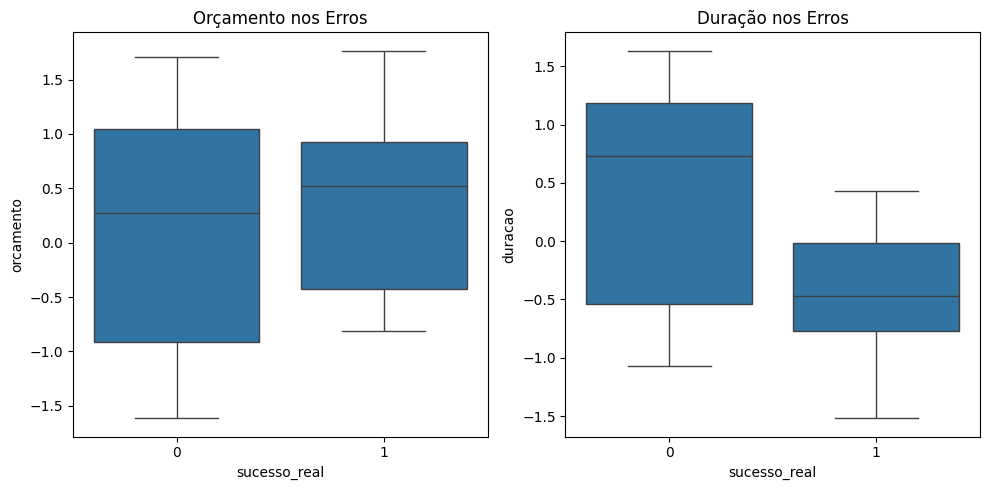


Melhores parâmetros para Random Forest: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 300}

Random Forest
F1-Score médio (CV): 0.9415 ± 0.0600
Accuracy: 0.7183
Precision: 0.7273
Recall: 0.9600
F1 Score: 0.8276
Confusion Matrix:
[[ 3 18]
 [ 2 48]]
Melhor limiar para F1: 0.4925 (F1: 0.8376)

Importância das Features para Random Forest:
Feature: orcamento, Importância: 0.2339
Feature: duracao, Importância: 0.1196
Feature: orcamento_por_membro, Importância: 0.0000
Feature: duracao_por_membro, Importância: 0.0000
Feature: duracao_x_equipe, Importância: 0.0000
Feature: equipe_extrema, Importância: 0.0000
Feature: orcamento_por_recurso, Importância: 0.2638
Feature: recursos_por_membro, Importância: 0.0000
Feature: orcamento_baixo, Importância: 0.0765
Feature: duracao_curta, Importância: 0.0197
Feature: duracao_por_recurso, Importância: 0.1050
Feature: orcamento_por_duracao, Importância: 0.1814

Análise detalhada de erros para Random 

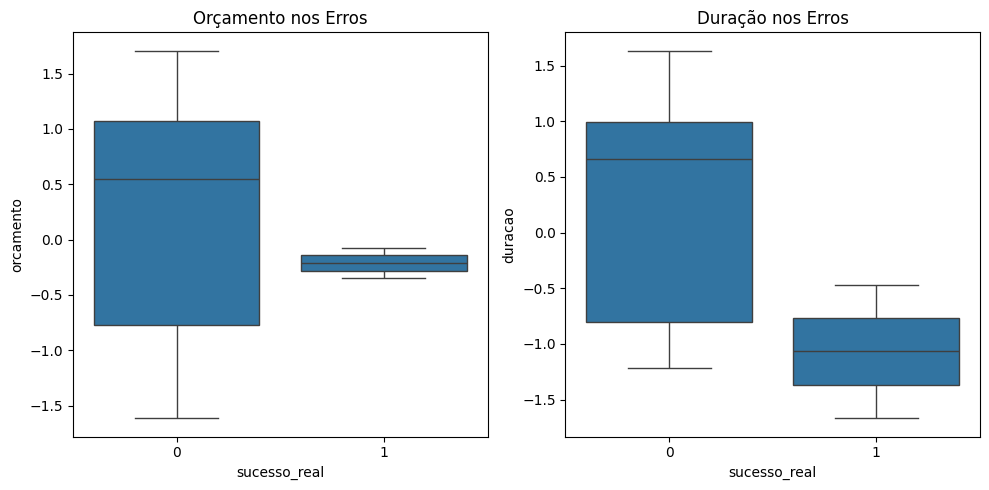


Melhores parâmetros para XGBoost: {'colsample_bytree': 0.7, 'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 300, 'scale_pos_weight': 2, 'subsample': 0.9}

XGBoost
F1-Score médio (CV): 0.9452 ± 0.0527
Accuracy: 0.7042
Precision: 0.7377
Recall: 0.9000
F1 Score: 0.8108
Confusion Matrix:
[[ 5 16]
 [ 5 45]]
Melhor limiar para F1: 0.3221 (F1: 0.8376)

XGBoost
F1-Score médio (CV): 0.9452 ± 0.0527
Accuracy: 0.7042
Precision: 0.7377
Recall: 0.9000
F1 Score: 0.8108
Confusion Matrix:
[[ 5 16]
 [ 5 45]]
Melhor limiar para F1: 0.3221 (F1: 0.8376)

Melhores parâmetros para CatBoost: {'depth': 6, 'iterations': 300, 'l2_leaf_reg': 3, 'learning_rate': 0.01}

Melhores parâmetros para CatBoost: {'depth': 6, 'iterations': 300, 'l2_leaf_reg': 3, 'learning_rate': 0.01}

CatBoost
F1-Score médio (CV): 0.9826 ± 0.0213
Accuracy: 0.5915
Precision: 0.7059
Recall: 0.7200
F1 Score: 0.7129
Confusion Matrix:
[[ 6 15]
 [14 36]]
Melhor limiar para F1: 0.3000 (F1: 0.8376)

Importância das Features para CatBoost:

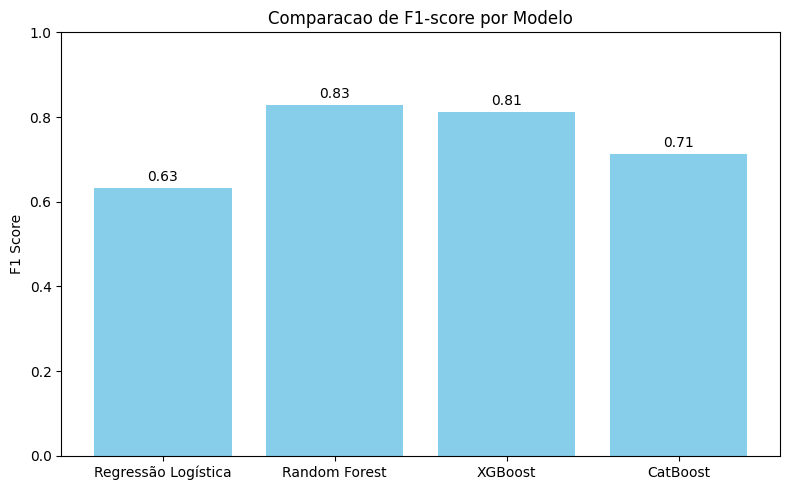

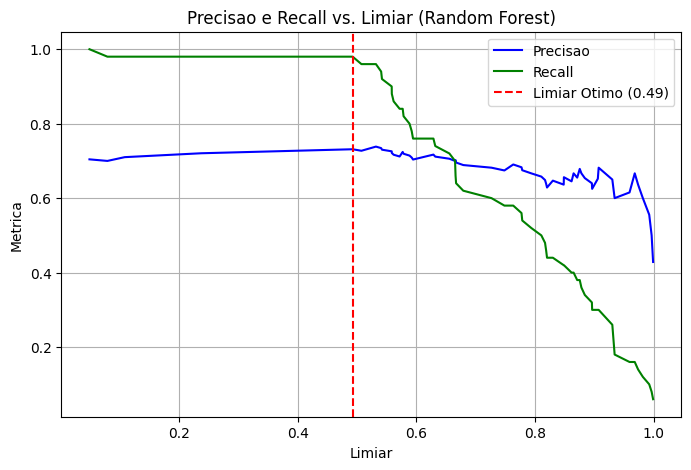


Melhores parâmetros para Regressão Logística: {'C': 100, 'penalty': 'l1', 'solver': 'liblinear'}

Regressão Logística
F1-Score médio (CV): 0.9826 ± 0.0213
Accuracy: 0.5070
Precision: 0.6667
Recall: 0.6000
F1 Score: 0.6316
Confusion Matrix:
[[ 6 15]
 [20 30]]
Melhor limiar para F1: 0.3000 (F1: 0.8264)

Análise detalhada de erros para Regressão Logística:
      orcamento   duracao  orcamento_por_membro  duracao_por_membro  \
343   0.579767 -0.167468                   0.0                 0.0   
22    0.344186 -1.367799                   0.0                 0.0   
289  -0.769870 -1.517841                   0.0                 0.0   
71    0.704562 -1.217758                   0.0                 0.0   
244  -0.811528 -0.317510                   0.0                 0.0   

     duracao_x_equipe  equipe_extrema  orcamento_por_recurso  \
343               0.0               0               0.579767   
22                0.0               0               0.344186   
289               0.0        

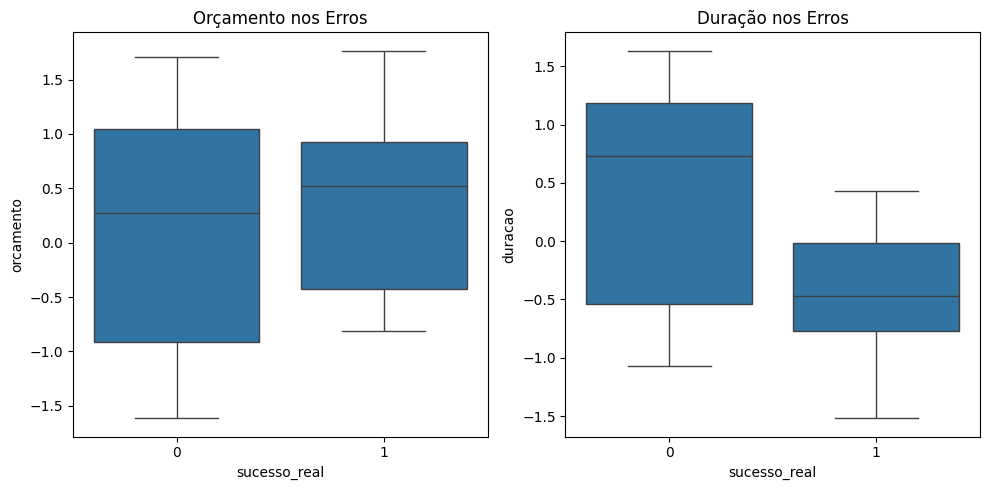


Melhores parâmetros para Random Forest: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 300}

Random Forest
F1-Score médio (CV): 0.9415 ± 0.0600
Accuracy: 0.7183
Precision: 0.7273
Recall: 0.9600
F1 Score: 0.8276
Confusion Matrix:
[[ 3 18]
 [ 2 48]]
Melhor limiar para F1: 0.4925 (F1: 0.8376)

Importância das Features para Random Forest:
Feature: orcamento, Importância: 0.2339
Feature: duracao, Importância: 0.1196
Feature: orcamento_por_membro, Importância: 0.0000
Feature: duracao_por_membro, Importância: 0.0000
Feature: duracao_x_equipe, Importância: 0.0000
Feature: equipe_extrema, Importância: 0.0000
Feature: orcamento_por_recurso, Importância: 0.2638
Feature: recursos_por_membro, Importância: 0.0000
Feature: orcamento_baixo, Importância: 0.0765
Feature: duracao_curta, Importância: 0.0197
Feature: duracao_por_recurso, Importância: 0.1050
Feature: orcamento_por_duracao, Importância: 0.1814

Análise detalhada de erros para Random 

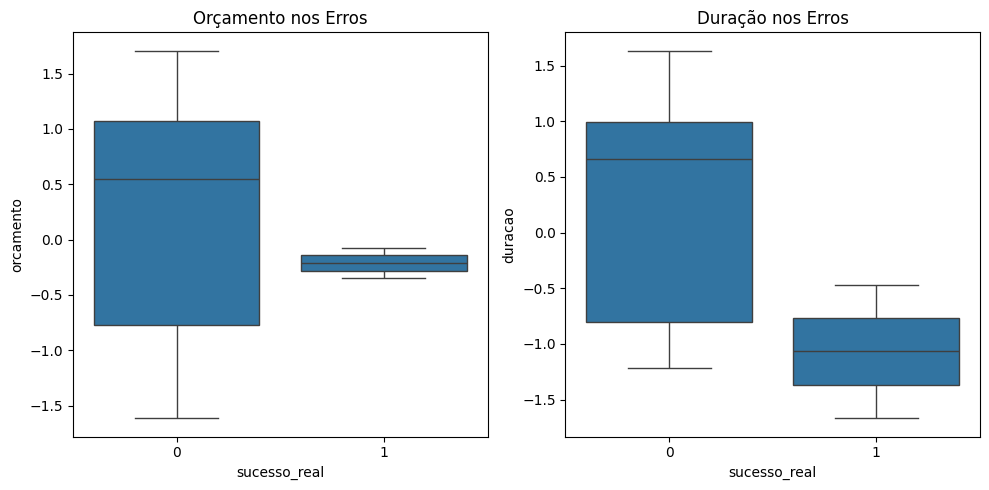


Melhores parâmetros para XGBoost: {'colsample_bytree': 0.7, 'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 300, 'scale_pos_weight': 2, 'subsample': 0.9}

XGBoost
F1-Score médio (CV): 0.9452 ± 0.0527
Accuracy: 0.7042
Precision: 0.7377
Recall: 0.9000
F1 Score: 0.8108
Confusion Matrix:
[[ 5 16]
 [ 5 45]]
Melhor limiar para F1: 0.3221 (F1: 0.8376)

XGBoost
F1-Score médio (CV): 0.9452 ± 0.0527
Accuracy: 0.7042
Precision: 0.7377
Recall: 0.9000
F1 Score: 0.8108
Confusion Matrix:
[[ 5 16]
 [ 5 45]]
Melhor limiar para F1: 0.3221 (F1: 0.8376)

Melhores parâmetros para CatBoost: {'depth': 6, 'iterations': 300, 'l2_leaf_reg': 3, 'learning_rate': 0.01}

Melhores parâmetros para CatBoost: {'depth': 6, 'iterations': 300, 'l2_leaf_reg': 3, 'learning_rate': 0.01}

CatBoost
F1-Score médio (CV): 0.9826 ± 0.0213
Accuracy: 0.5915
Precision: 0.7059
Recall: 0.7200
F1 Score: 0.7129
Confusion Matrix:
[[ 6 15]
 [14 36]]
Melhor limiar para F1: 0.3000 (F1: 0.8376)

Importância das Features para CatBoost:

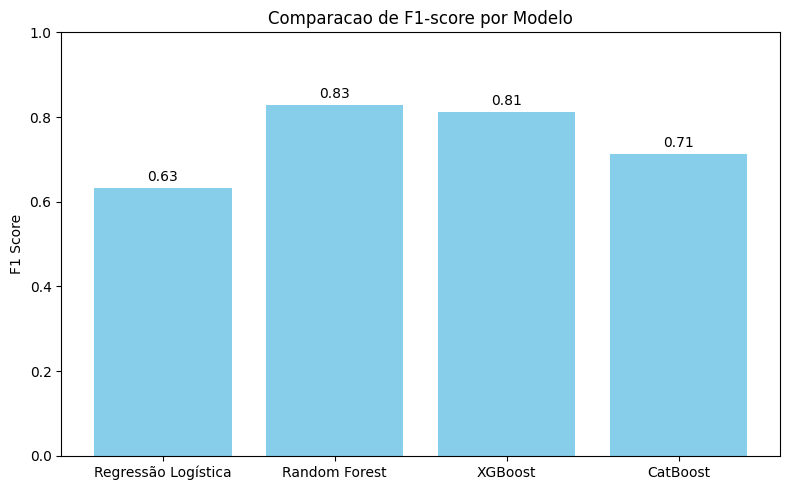

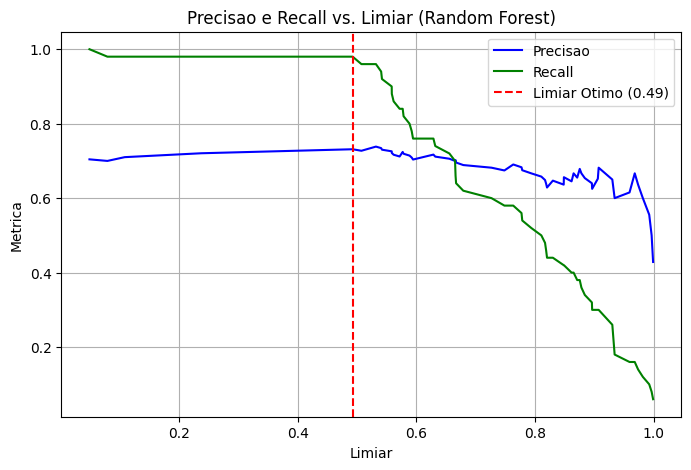


Melhor modelo: Random Forest (F1 = 0.8376, Limiar = 0.4925) salvo em: ../model.pkl


In [14]:
# Features e target
X = df[[
'orcamento', 'duracao', 
        'orcamento_por_membro', 'duracao_por_membro', 'duracao_x_equipe', 
        'equipe_extrema', 'orcamento_por_recurso', 'recursos_por_membro', 
        'orcamento_baixo', 'duracao_curta', 'duracao_por_recurso', 'orcamento_por_duracao'
]]
y = df['sucesso']
# Preencher NaNs com zero nas features
X = X.fillna(0)
# Normalização das variáveis numéricas
scaler = StandardScaler()
X = X.copy()
numeric_cols = ['orcamento', 'duracao', 'orcamento_por_membro', 'duracao_por_membro', 
                'duracao_x_equipe', 'orcamento_por_recurso', 'recursos_por_membro', 
                'duracao_por_recurso', 'orcamento_por_duracao']
X[numeric_cols] = X[numeric_cols].astype(float)
X.loc[:, numeric_cols] = scaler.fit_transform(X[numeric_cols])

# Divisão treino/teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=RANDOM_STATE)

# Balanceamento com SMOTEENN
smote_enn = SMOTEENN(sampling_strategy=0.7, random_state=RANDOM_STATE)
X_resampled, y_resampled = smote_enn.fit_resample(X_train, y_train)

# Dicionário de modelos
modelos = {
    'Regressão Logística': LogisticRegression(max_iter=5000, class_weight='balanced', random_state=RANDOM_STATE),
    'Random Forest': RandomForestClassifier(class_weight='balanced', random_state=RANDOM_STATE),
    'XGBoost': XGBClassifier(eval_metric='logloss', random_state=RANDOM_STATE),
    'CatBoost': CatBoostClassifier(random_state=RANDOM_STATE, verbose=0)
}

# Parâmetros para GridSearchCV
param_grids = {
    'Regressão Logística': [
        {'C': [10, 50, 100, 200], 'solver': ['liblinear'], 'penalty': ['l1', 'l2']},
        {'C': [10, 50, 100, 200], 'solver': ['saga'], 'penalty': ['l1', 'l2']},
        {'C': [10, 50, 100, 200], 'solver': ['saga'], 'penalty': ['elasticnet'], 'l1_ratio': [0.1, 0.5, 0.9]}
    ],
    'Random Forest': {
        'n_estimators': [200, 300, 400],
        'max_depth': [10, 20, 30],
        'min_samples_split': [2, 5],
        'min_samples_leaf': [2, 4, 6],
        'max_features': ['sqrt', 'log2']
    },
    'XGBoost': {
        'n_estimators': [100, 200, 300],
        'max_depth': [3, 6, 9],
        'learning_rate': [0.01, 0.05, 0.1],
        'scale_pos_weight': [1, 2, 3],
        'subsample': [0.7, 0.9],
        'colsample_bytree': [0.7, 0.9]
    },
    'CatBoost': {
        'iterations': [100, 200, 300],
        'depth': [4, 6, 8],
        'l2_leaf_reg': [1, 3, 5],
        'learning_rate': [0.01, 0.05]
    }
}

resultados = {}
melhor_modelo = None
melhor_nome = ""
melhor_f1 = 0
melhor_threshold = 0.3

# Treinar, avaliar e comparar modelos
for nome, modelo in modelos.items():
    # Ajuste de hiperparâmetros
    if nome in param_grids:
        grid_search = GridSearchCV(
            modelo, param_grids[nome], cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE),
            scoring='f1', n_jobs=-1
        )
        grid_search.fit(X_resampled, y_resampled)
        modelo = grid_search.best_estimator_
        print(f"\nMelhores parâmetros para {nome}: {grid_search.best_params_}")
    
    # Treinamento
    modelo.fit(X_resampled, y_resampled)
    
    # Validação cruzada
    cv_scores = cross_val_score(modelo, X_resampled, y_resampled, cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE), scoring='f1')
    print(f"\n{nome}")
    print(f"F1-Score médio (CV): {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")
    
    # Predição no conjunto de teste com limiar padrão
    y_pred = modelo.predict(X_test)
    
    # Métricas
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    resultados[nome] = {'accuracy': acc, 'precision': prec, 'recall': rec, 'f1': f1}
    print(f"Accuracy: {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall: {rec:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"Confusion Matrix:\n{confusion_matrix(y_test, y_pred)}")
    
    # Ajuste do limiar de decisão
    if hasattr(modelo, 'predict_proba'):
        y_scores = modelo.predict_proba(X_test)[:, 1]
        precisions, recalls, thresholds = precision_recall_curve(y_test, y_scores)
        f1_scores = 2 * (precisions * recalls) / (precisions + recalls + 1e-10)
        optimal_idx = np.argmax(f1_scores)
        optimal_threshold = max(0.3, thresholds[optimal_idx])
        print(f"Melhor limiar para F1: {optimal_threshold:.4f} (F1: {f1_scores[optimal_idx]:.4f})")
        
        # Reavaliar com limiar ajustado
        y_pred_adjusted = (y_scores >= optimal_threshold).astype(int)
        f1_adjusted = f1_score(y_test, y_pred_adjusted)
        # Priorizar Random Forest se F1 médio for alto e recall for bom
        if (nome == 'Random Forest' and cv_scores.mean() >= 0.8 and rec > 0.7) or \
           (f1_adjusted > melhor_f1 and nome != 'Random Forest'):
            melhor_f1 = f1_adjusted
            melhor_modelo = modelo
            melhor_nome = nome
            melhor_threshold = optimal_threshold
    
    else:
        if f1 > melhor_f1:
            melhor_f1 = f1
            melhor_modelo = modelo
            melhor_nome = nome

    # Importância das features
    if nome in ['Random Forest', 'CatBoost'] and hasattr(modelo, 'feature_importances_'):
        importances = modelo.feature_importances_
        feature_names = X.columns
        print(f"\nImportância das Features para {nome}:")
        for name, imp in zip(feature_names, importances):
            print(f"Feature: {name}, Importância: {imp:.4f}")

    # Análise de erros
    if nome == melhor_nome:
        errors = X_test[y_test != y_pred].copy()
        errors['sucesso_real'] = y_test[y_test != y_pred]
        errors['sucesso_predito'] = y_pred[y_test != y_pred]
        print(f"\nAnálise detalhada de erros para {nome}:\n", errors.head())
        errors_stats = errors.groupby('sucesso_real').mean()
        print(f"Estatísticas dos erros por classe:\n", errors_stats)

        # Visualização dos erros
        plt.figure(figsize=(10, 5))
        plt.subplot(1, 2, 1)
        sns.boxplot(x='sucesso_real', y='orcamento', data=errors)
        plt.title('Orçamento nos Erros')
        plt.subplot(1, 2, 2)
        sns.boxplot(x='sucesso_real', y='duracao', data=errors)
        plt.title('Duração nos Erros')
        plt.tight_layout()
        plt.show()

# Feature Selection com RFE apenas para visualização
if melhor_modelo:
    rfe = RFE(estimator=RandomForestClassifier(random_state=RANDOM_STATE), n_features_to_select=7)
    rfe.fit(X_resampled, y_resampled)
    selected_features_rfe = X.columns[rfe.support_].tolist()
    print("\nFeatures sugeridas pelo RFE (para análise):", selected_features_rfe)

# Gráfico comparativo de F1-score
labels = list(resultados.keys())
f1_scores = [resultados[n]['f1'] for n in labels]

plt.figure(figsize=(8, 5))
bars = plt.bar(labels, f1_scores, color='skyblue')
plt.title('Comparacao de F1-score por Modelo')
plt.ylabel('F1 Score')
plt.ylim(0, 1)
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval + 0.01, f'{yval:.2f}', ha='center', va='bottom')
plt.tight_layout()
plt.show()

# Gráfico de precisão e recall para melhor modelo
if hasattr(melhor_modelo, 'predict_proba'):
    y_scores = melhor_modelo.predict_proba(X_test)[:, 1]
    precisions, recalls, thresholds = precision_recall_curve(y_test, y_scores)
    plt.figure(figsize=(8, 5))
    plt.plot(thresholds, precisions[:-1], label='Precisao', color='b')
    plt.plot(thresholds, recalls[:-1], label='Recall', color='g')
    plt.axvline(x=melhor_threshold, color='r', linestyle='--', label=f'Limiar Otimo ({melhor_threshold:.2f})')
    plt.xlabel('Limiar')
    plt.ylabel('Metrica')
    plt.title(f'Precisao e Recall vs. Limiar ({melhor_nome})')
    plt.legend()
    plt.grid(True)
    plt.show()

# Salvar o modelo final com todas as features utilizadas no treino
selected_features = list(X.columns)

joblib.dump({
    'model': melhor_modelo,
    'threshold': melhor_threshold,
    'scaler': scaler,
    'selected_features': selected_features
}, OUTPUT_MODEL)

print(f"\nMelhor modelo: {melhor_nome} (F1 = {melhor_f1:.4f}, Limiar = {melhor_threshold:.4f}) salvo em: {OUTPUT_MODEL}")
